In [1]:
#load_exp collaborative_filtering

In [2]:
#export
import numpy as np
import pandas as pd
import scipy

import itertools
from functools import partial
import attr

import fastai
from fastai import collab, tabular
import implicit
from sklearn import compose, preprocessing, metrics
import fastFM.sgd
import fastFM.als
import tqdm
import seaborn as sns

import matplotlib.pyplot as plt

from game_recommender import steam_data

# Collaborative filtering

In this notebook recommendation algorithms are trained on 'log_hours' column.

I used this feature because in absence of ratings it can serve as feedback whether user liked a game.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

In [4]:

%cd ..
%matplotlib inline

/home/kuba/Projects/game_recommender


In [5]:
raw_steam_ratings_df = steam_data.prepare_target(
    steam_data.load_steam_ratings_df()
)

In [6]:
min_review_threshold = 3

In [7]:
raw_user_review_counts = raw_steam_ratings_df.groupby('user_id').agg('count').iloc[:,0]
(raw_user_review_counts > min_review_threshold).mean()

0.24995594713656388

In [8]:
def get_column_with_sufficient_reviews(ratings_df, col, threshold):
    game_review_counts = ratings_df.groupby(col).agg('count').iloc[:,0]
    return ratings_df[col].isin(
        game_review_counts.index[game_review_counts >= threshold]
    )

In [9]:
game_review_counts = raw_steam_ratings_df.groupby('name').agg('count').iloc[:,0]

## Filtering data

We need to exclude games and users with low number of reviews - for users with insufficient number of reviewed games the estimates will be very unstable

In [10]:
steam_ratings_df = raw_steam_ratings_df[get_column_with_sufficient_reviews(raw_steam_ratings_df, 'user_id', 5)]
steam_ratings_df = steam_ratings_df[get_column_with_sufficient_reviews(steam_ratings_df, 'name', 4)]

In [11]:
steam_ratings_df.shape

(54929, 7)

## Number of games

In [12]:
steam_ratings_df['name'].nunique()

1752

In [13]:
steam_ratings_df['name'].value_counts().describe()

count    1752.000000
mean       31.352169
std        67.536642
min         4.000000
25%         6.000000
50%        12.000000
75%        30.000000
max      1181.000000
Name: name, dtype: float64

## Number of users 

In [14]:
steam_ratings_df['user_id'].nunique()

2435

In [15]:
steam_ratings_df['user_id'].value_counts().describe()

count    2435.000000
mean       22.558111
std        29.689343
min         2.000000
25%         7.000000
50%        12.000000
75%        24.000000
max       343.000000
Name: user_id, dtype: float64

## Predicted column - log_hours

In [16]:
steam_ratings_df['log_hours'].describe()

count    54929.000000
mean         2.045742
std          1.559676
min          0.095310
25%          0.741937
50%          1.740466
75%          2.990720
max          9.253687
Name: log_hours, dtype: float64

## Played game counts - cumulative distribution function

Max number of played games was truncated at $q = 95$ percentile 

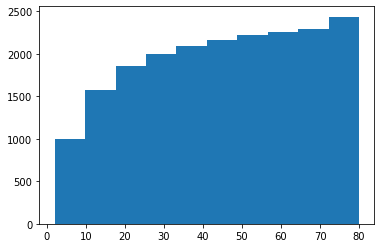

In [17]:
user_review_counts = steam_ratings_df.groupby('user_id').agg('count').iloc[:,0]
q = user_review_counts.quantile(0.95)
truncated_review_counts = np.minimum(user_review_counts, q)
plt.hist(truncated_review_counts, cumulative=1);

# Train test split

Splitting is nontrivial matter here: different algorithms use different encoding schemes:
        
- Factorization Machines and FastAI collaborative filtering use supervised learning convention (inputs are one-hot encoded user and item columns)
- Matrix Factorization algorithms use user-item matrix

In [18]:
from sklearn import model_selection

labels_train, labels_val = model_selection.train_test_split(
    range(len(steam_ratings_df)),
    stratify=steam_ratings_df['name']
)

In [19]:
import scipy


def encode_user_item_matrix(ratings_df):
    item_user_pivoted_df = ratings_df.pivot_table(index='name', columns='user_id', values='log_hours')
    item_user_matrix = scipy.sparse.csr_matrix(item_user_pivoted_df.fillna(0).values)
    return scipy.sparse.csr_matrix(item_user_matrix.T)

user_game_matrix_train = encode_user_item_matrix(steam_ratings_df.iloc[labels_train])
user_game_matrix_val = encode_user_item_matrix(steam_ratings_df.iloc[labels_val])
user_game_matrix_train.shape, user_game_matrix_val.shape

((2434, 1752), (2264, 1752))

# FastAI Collaborative Filtering model

In [20]:
steam_databunch = (
    collab.CollabList.from_df(
        steam_ratings_df,
        cat_names=['user_id', 'name'],
        procs=tabular.Categorify)
    .split_by_idxs(labels_train, labels_val)
    .label_from_df('log_hours')
).databunch(path=None, bs=16)

In [21]:
nn_cf_learner =  collab.collab_learner(
    steam_databunch,
    n_factors=10,
    y_range=(0,10),
    emb_drop=0.5,
    use_nn=True,
    layers=[10, 10]
)

In [22]:
nn_cf_learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-01


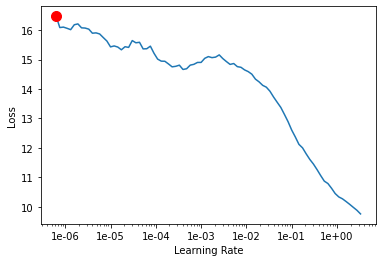

In [23]:
nn_cf_learner.recorder.plot(suggestion=True)

In [24]:
nn_cf_learner.fit_one_cycle(
    10, max_lr=1e-3,
)

epoch,train_loss,valid_loss,time
0,2.871823,2.446870,00:11
1,1.781752,1.793390,00:10
2,1.728254,1.740134,00:11
3,1.638417,1.694271,00:11
4,1.714763,1.694711,00:12
5,1.560444,1.686408,00:12
6,1.532756,1.698104,00:11
7,1.555932,1.707695,00:11
8,1.485515,1.717206,00:11
9,1.502717,1.707229,00:12


In [25]:
nn_cf_learner.show_results(rows=50)

user_id,name,target,prediction
44426653,Team Fortress 2,0.18232156,[2.704972]
35701646,Deus Ex Human Revolution - Director's Cut,1.1631508,[2.615347]
194432540,Unturned,2.104134,[1.706013]
160887309,Tribes Ascend,1.0647107,[0.899926]
11403772,Might & Magic Clash of Heroes,0.09531018,[2.613361]
197949629,Rocket League,1.2809339,[2.885777]
49191483,Half-Life Deathmatch Source,0.09531018,[0.610608]
31187179,From Dust,0.74193734,[1.147026]
81591317,Sniper Elite V2,1.3862944,[1.254268]
180901075,Yet Another Zombie Defense,0.53062826,[0.759265]


In [26]:
nn_preds_val = nn_cf_learner.get_preds()

In [27]:
target_val = steam_ratings_df['log_hours'][labels_val]

In [28]:
evaluation_df = steam_ratings_df.iloc[labels_val]
evaluation_df['nn_preds'] = nn_preds_val[0].numpy().reshape(-1)

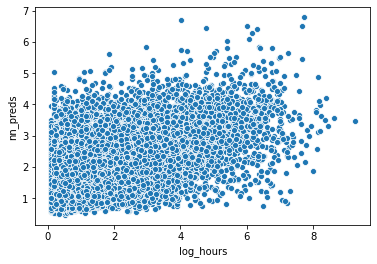

In [29]:
sns.scatterplot(data=evaluation_df, x='log_hours', y='nn_preds');

In [30]:
def get_prediction_spearman_correlation(evaluation_df, col, pred_col):
    return  evaluation_df.groupby('user_id').agg(
        lambda df: scipy.stats.spearmanr(
            df[pred_col], df[col])[0]
    )['name']

In [31]:
nn_spearman_correlations = get_prediction_spearman_correlation(evaluation_df, 'nn_preds', 'log_hours')

/etc/conda/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/etc/conda/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/etc/conda/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/etc/conda/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/etc/conda/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


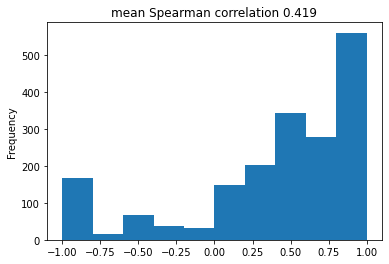

In [32]:
plt.title('mean Spearman correlation {:,.3f}'.format(nn_spearman_correlations.mean()))
nn_spearman_correlations.plot.hist();

# Factorization Machines

In [33]:
fm_coltransformer = compose.ColumnTransformer(
    [
        ('user_id', preprocessing.OneHotEncoder(), ['user_id']),
        ('name', preprocessing.OneHotEncoder(), ['name'])
    ]
)

In [34]:
X_fm = fm_coltransformer.fit_transform(steam_ratings_df)
X_fm_train = X_fm[labels_train]
X_fm_val = X_fm[labels_val]

y_fm_train = steam_ratings_df['log_hours'].iloc[labels_train]
y_fm_val = steam_ratings_df['log_hours'].iloc[labels_val]

In [35]:
def run_fm_experiments(
        fm_cls, ranks,
        n_iters,
        data_train=(X_fm_train, y_fm_train),
        data_val=(X_fm_val, y_fm_val),
        **kwargs
    ):
    fm_sgd_results = []
    best_model = None
    best_val_error = np.inf 
    
    for (rank, n_iter) in tqdm.tqdm(
        itertools.product(ranks, n_iters),
        total=len(ranks) * len(n_iters)
    ):
        init_stdev = kwargs.pop('init_stdev') if  kwargs.get('init_stdev') else 1/rank
        fm_model = fm_cls(rank=rank, n_iter=n_iter, init_stdev=1/rank, **kwargs)
        fm_model.fit(*data_train)

        train_error = metrics.mean_squared_error(data_train[1], fm_model.predict(data_train[0]))
        val_error = metrics.mean_squared_error(data_val[1], fm_model.predict(data_val[0]))

        fm_sgd_results.append({'n_factors': rank, 'n_iter': n_iter, 'train_error': train_error, 'val_error': val_error})
        if val_error < best_val_error or best_model is None:
            best_val_error = val_error
            best_model = fm_model
    return round(pd.DataFrame(fm_sgd_results), 3), fm_model

In [36]:
fm_sgd_ranks = [5, 10, 25, 50, 100, 250, 500]
fm_sgd_n_iters = range(3000, 6000 + 1, 500)


fm_sgd_results, fm_sgd_model = run_fm_experiments(fastFM.sgd.FMRegression, fm_sgd_ranks, fm_sgd_n_iters, l2_reg=0.1)

100%|██████████| 49/49 [00:05<00:00,  8.43it/s] 


## runs with n_factors minimizing validation error

In [37]:
best_n_iter_results_df = pd.DataFrame(fm_sgd_results).groupby('n_factors').agg(lambda df: df[df['val_error'] == df['val_error'].min()].iloc[0])

best_n_iter_results_df

,n_iter,train_error,val_error
n_factors,,,
5,5500.0,1.906,1.974
10,5500.0,1.894,1.957
25,5500.0,1.893,1.950
50,5500.0,1.894,1.950
100,5500.0,1.895,1.950
250,5500.0,1.896,1.950
500,5500.0,1.896,1.950


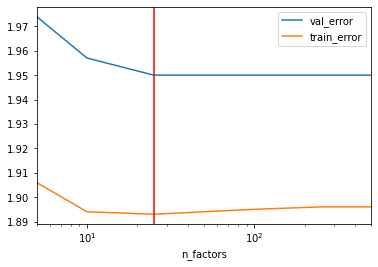

In [38]:
best_n_iter_results_df[['val_error', 'train_error']].plot()
plt.axvline(best_n_iter_results_df['val_error'].idxmin() , c='red')
plt.xscale('log');

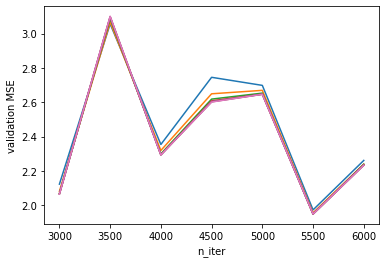

In [39]:
for rank in fm_sgd_ranks:
    fm_rank_results_df = fm_sgd_results[fm_sgd_results['n_factors'] == rank] 
    plt.plot(fm_rank_results_df['n_iter'], fm_rank_results_df['val_error'])
    plt.ylabel('validation MSE')
    plt.xlabel('n_iter')

In [40]:
fm_sgd_pred = fm_sgd_model.predict(X_fm_val)

evaluation_df['fm_sgd_preds'] =  fm_sgd_pred

In [41]:
evaluation_df.columns

Index(['user_id', 'name', 'ownership', 'hours', 'log_hours', 'played',
       'interacted', 'nn_preds', 'fm_sgd_preds'],
      dtype='object')

In [42]:
fm_sgd_spearman_correlations = get_prediction_spearman_correlation(evaluation_df, 'fm_sgd_preds', 'log_hours')

/etc/conda/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/etc/conda/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/etc/conda/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/etc/conda/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/etc/conda/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [43]:
fm_sgd_spearman_correlations.mean()

0.34511889438275495

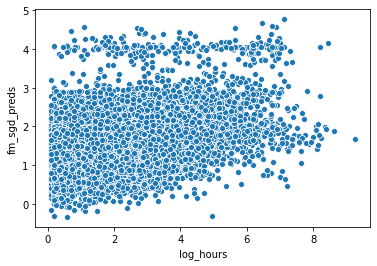

In [44]:
sns.scatterplot(data=evaluation_df, x='log_hours', y='fm_sgd_preds');

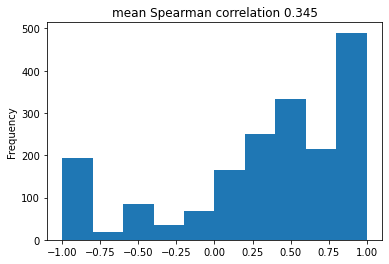

In [45]:
plt.title('mean Spearman correlation {:,.3f}'.format(fm_sgd_spearman_correlations.mean()))
fm_sgd_spearman_correlations.plot.hist();

# Factorization machines trained with Alternating Least Squares

In [46]:
fm_als_ranks = [5, 10, 25, 50]
fm_als_n_iters = [10, 25, 50, 100] 

fm_als_results, fm_als_model = run_fm_experiments(
    fastFM.als.FMRegression, fm_als_ranks,
    fm_als_n_iters,
    l2_reg=25.0
)

100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


In [47]:
best_n_iter_results_df = pd.DataFrame(fm_als_results).groupby('n_factors').agg(lambda df: df[df['val_error'] == df['val_error'].min()].iloc[0])
best_n_iter_results_df

,n_iter,train_error,val_error
n_factors,,,
5,100.0,1.319,1.706
10,10.0,1.311,1.706
25,10.0,1.310,1.706
50,10.0,1.311,1.706


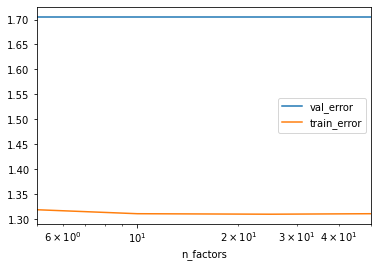

In [48]:
best_n_iter_results_df[['val_error', 'train_error']].plot()
plt.xscale('log');

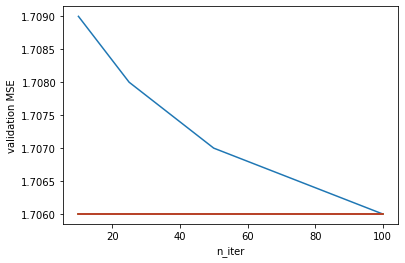

In [49]:
for rank in fm_als_ranks:
    fm_rank_results_df = fm_als_results[fm_als_results['n_factors'] == rank] 
    plt.plot(fm_rank_results_df['n_iter'], fm_rank_results_df['val_error'])
    plt.ylabel('validation MSE')
    plt.xlabel('n_iter')

In [50]:
fm_als_pred = fm_als_model.predict(X_fm_val)
evaluation_df['fm_als_preds'] =  fm_als_pred

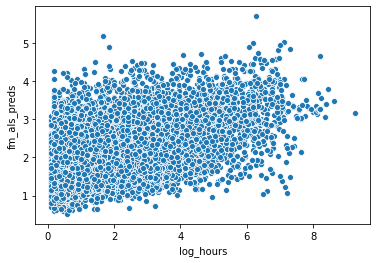

In [51]:
sns.scatterplot(data=evaluation_df, x='log_hours', y='fm_als_preds');

/etc/conda/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/etc/conda/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/etc/conda/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/etc/conda/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/etc/conda/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


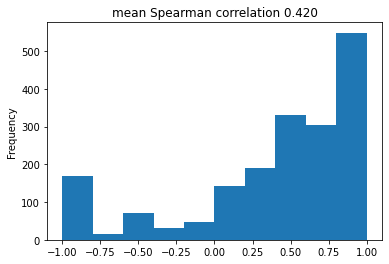

In [52]:
fm_als_spearman_correlations = get_prediction_spearman_correlation(evaluation_df, 'fm_als_preds', 'log_hours')
plt.title('mean Spearman correlation {:,.3f}'.format(fm_als_spearman_correlations.mean()))
fm_als_spearman_correlations.plot.hist();

# Embarassingly Shallow Autoencoder

Model from [Embarrassingly Shallow Autoencoders for Sparse Data](https://arxiv.org/pdf/1905.03375.pdf)

In [53]:
n_experiments = 20
lambdas = np.logspace(0, 3, n_experiments)
losses = np.empty_like(lambdas)

In [54]:
from mlutil import recommendation

In [55]:
for i, lambda_ in tqdm.tqdm(enumerate(lambdas), total=n_experiments):
    esa = recommendation.EmbarrasinglyShallowAutoencoder(lambda_)
    esa.fit(user_game_matrix_train)
    loss = esa.score_reconstruction(user_game_matrix_val.toarray())
    losses[i] = loss 

100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


In [56]:
lambdas[losses.argmin()], losses.min()

(37.926901907322495, 5.812888952280237)

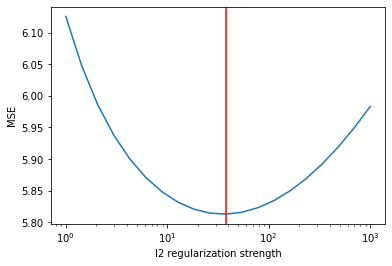

In [57]:
i = 10 
plt.plot(lambdas, losses)
plt.xscale('log');
plt.axvline(lambdas[losses.argmin()], c='red')
plt.xlabel('l2 regularization strength')
plt.ylabel('MSE');